In [1]:
import numpy as np
import pickle
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Step 1: Load the pickle file
with open("plate_curves.pkl", "rb") as f:
    raw_data = pickle.load(f)

# Step 2: Parse the structure into Vp_data, Vg_data, Ia_data
Vp_data = []
Vg_data = []
Ia_data = []

for key, values in raw_data.items():
    if key.startswith("gv"):
        try:
            Vg_val = float(key.replace("gv", ""))
        except ValueError:
            continue  # skip keys that aren't voltage traces
    Vp_sub_data = []
    Ia_sub_data = []
    Vg_sub_data = []
    for value in values:
        Vp, Ia = value
        Vp_sub_data.append(Vp)
        Ia_sub_data.append(Ia)
        Vg_sub_data.append(Vg_val)
    Vp_data.append(np.array(Vp_sub_data))
    Ia_data.append(np.array(Ia_sub_data))
    Vg_data.append(np.array(Vg_sub_data))

# Step 4: Define the extended Koren model function
def extended_koren_model(X, kp, kg, kv, gamma):
    Vp, Vg, mu = X
    U = mu / (2 * kv) * (Vg + Vp / mu)
    ln_term = np.log1p(np.exp(U))  # numerically stable
    P = (Vp + kp) ** 1.5
    return (P / kg) * (ln_term ** gamma)

Vp = np.linspace(0, 300, 301)
Vg_list = [0, -0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4, -4.5]
mu = 100
popts = []

for Vp, Vg, Ia in zip(Vp_data, Vg_data, Ia_data):
    # Step 5: Prepare X tuple for curve fitting
    X_data = (Vp, Vg, np.full(np.shape(Vp), mu, dtype=np.float32))
    
    # Step 6: Provide initial guess and bounds
    initial_guess = [300, 1060, 1.73, 1.3]  # kp, kg, kv, gamma
    bounds = ([10, 10, 0.1, 0.5], [1000, 10000, 10, 3.0])
    
    # Step 7: Fit the model (optional – remove comment to run)
    popt, _ = curve_fit(extended_koren_model, X_data, Ia,
                        p0=initial_guess, bounds=bounds)
    
    popts.append(popt)
popts = np.nanmean(popts, axis = 0)
print([format(i, 'f') for i in popts])

['32.858207', '9800.941141', '8.592783', '0.520735']


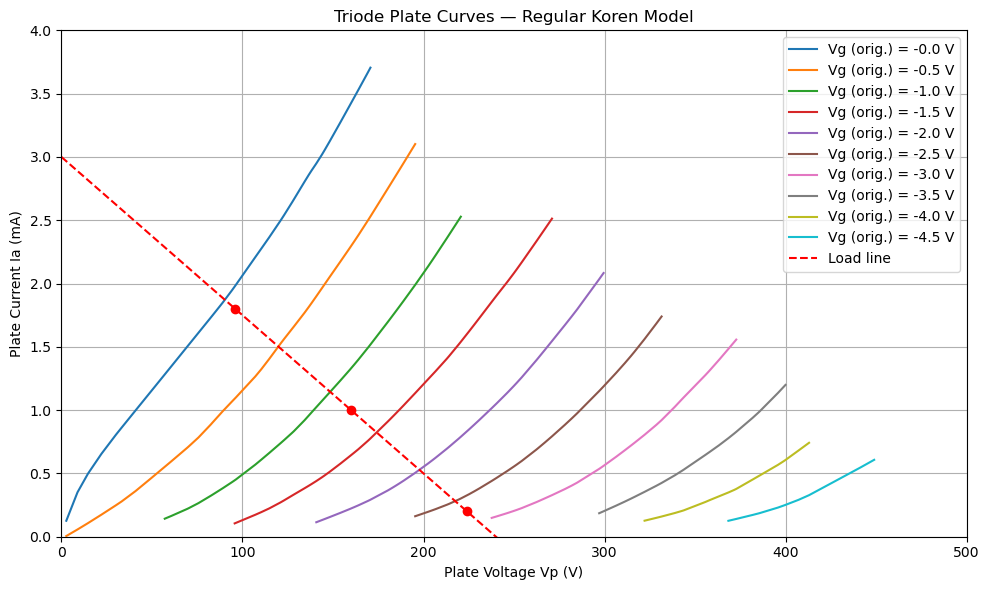

In [28]:
# Define Triode class
class Triode:
    def __init__(self, Vp, Vg_list, mu, kp, kg, kv, gamma = None):
        self.Ip = []
        for Vg in Vg_list:
            if not gamma:
                # Regular Koren Model
                E1 = np.log(1 + np.exp(mu * (Vg + Vp / mu) / (2 * kv)))
                self.Ip.append(((Vp + kp)**1.5 / kg) * E1**2)
            else:
                # Extended Koren Model
                P = (Vp + kp) ** 1.5
                U = mu / (2 * kv) * (Vg + Vp / mu)
                ln_term = np.log1p(np.exp(U))  # log(1 + exp(U))
                self.Ip.append((P / kg) * (ln_term ** gamma))
    def load_line(self, B_plus, anode_resist, cathode_resist, plate_current, pk_pk, output_impede = None, ccs = False):
        self.B_plus = B_plus
        self.anode_resist = anode_resist
        self.cathode_resist = cathode_resist
        self.plate_current = plate_current
        self.pk_pk = pk_pk
        self.max_current = (B_plus / anode_resist) * 1000 # b
        self.load_m = -self.max_current / B_plus # m
        self.Vg = - (plate_current / 1000) * cathode_resist

# Tube model parameters from optimization
mu = 100 # Amplification factor
kp = popts[0] # Plate voltage shaping constant
kg = popts[1] # Perveance scaling factor
kv = popts[2] # Exponential shaping constant

# Voltage sweep
Vp = np.linspace(0, 500, 501)
Vg_list = [-4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0]
triode = Triode(Vp, Vg_list, mu, kp, kg, kv)

# Plotting
plt.figure(figsize=(10, 6))
# Optimized Regular Koren Model
# for Vg, Ip in zip(Vg_list, triode.Ip):
#     plt.plot(Vp, Ip, label=f'Vg (opt. Koren) = {Vg:.1f} V', linestyle='--')

# Traced from data sheet
for Vp_datum, Vg_datum, Ia_datum in zip(Vp_data, Vg_data, Ia_data):
    plt.plot(Vp_datum, Ia_datum, label=f'Vg (orig.) = -{Vg_datum[0]:.1f} V')

# Plot load line
triode.load_line(240, 80000, 1250, 1, 2) # plate_current in milliamps
y = triode.load_m * Vp + triode.max_current # y = mx + b
plt.plot(Vp, y, label = "Load line", color='red', linestyle='--')

# Plot operating point
pseudo_Vp_op = (triode.plate_current - triode.max_current) / triode.load_m # y = mx + b
plt.plot(pseudo_Vp_op, triode.plate_current, color='red', marker='o', linestyle = "none")

# Plot pk-pk extent
Ia_pk_pk_lo = (-(triode.Vg + (triode.pk_pk / 2)) / triode.cathode_resist) * 1000
Ia_pk_pk_hi = (-(triode.Vg - (triode.pk_pk / 2)) / triode.cathode_resist) * 1000
pseudo_Vp_pk_pk_lo = (Ia_pk_pk_lo - triode.max_current) / triode.load_m # y = mx + b
pseudo_Vp_pk_pk_hi = (Ia_pk_pk_hi - triode.max_current) / triode.load_m # y = mx + b
plt.plot(pseudo_Vp_pk_pk_lo, Ia_pk_pk_lo, color='red', marker='o', linestyle = "none")
plt.plot(pseudo_Vp_pk_pk_hi, Ia_pk_pk_hi, color='red', marker='o', linestyle = "none")

# # Original Koren Model parameters
# mu = 100 # Amplification factor
# kp = 300 # Plate voltage shaping constant
# kg = 1060 # Perveance scaling factor
# kv = 1.73 # Exponential shaping constant
# triode = Triode(Vp, Vg_list, mu, kp, kg, kv)
# for Vg, Ip in zip(Vg_list, triode.Ip):
#     plt.plot(Vp, Ip, label=f'Vg (orig. Koren) = {Vg:.1f} V', linestyle='-.')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.xlim([0, 500])
plt.ylim([0, 4])
plt.title('Triode Plate Curves — Regular Koren Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# # Tube model parameters from optimization
# mu = 100 # Amplification factor
# kp = popts[0] # Plate voltage shaping constant
# kg = popts[1] # Perveance scaling factor
# kv = popts[2] # Exponential shaping constant
# gamma = popts[3] # Curvature exponent
# triode = Triode(Vp, Vg_list, mu, kp, kg, kv, gamma)

# # Plotting
# plt.figure(figsize=(10, 6))
# # Optimized Extended Koren Model
# for Vg, Ip in zip(Vg_list, triode.Ip):
#     plt.plot(Vp, Ip, label=f'Vg (opt. Koren) = {Vg:.1f} V', linestyle='--')

# # Traced from data sheet
# for Vp_datum, Vg_datum, Ia_datum in zip(Vp_data, Vg_data, Ia_data):
#     plt.plot(Vp_datum, Ia_datum, label=f'Vg (orig.) = -{Vg_datum[0]:.1f} V')

# # Original Koren Model parameters
# mu = 100 # Amplification factor
# kp = 300 # Plate voltage shaping constant
# kg = 1060 # Perveance scaling factor
# kv = 1.73 # Exponential shaping constant
# gamma = 1.3  # Curvature exponent
# triode = Triode(Vp, Vg_list, mu, kp, kg, kv)
# for Vg, Ip in zip(Vg_list, triode.Ip):
#     plt.plot(Vp, Ip, label=f'Vg (orig. Koren) = {Vg:.1f} V', linestyle='-.')

# plt.xlabel('Plate Voltage Vp (V)')
# plt.ylabel('Plate Current Ia (mA)')
# plt.xlim([0, 500])
# plt.ylim([0, 4])
# plt.title('Triode Plate Curves — Extended Koren Model')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

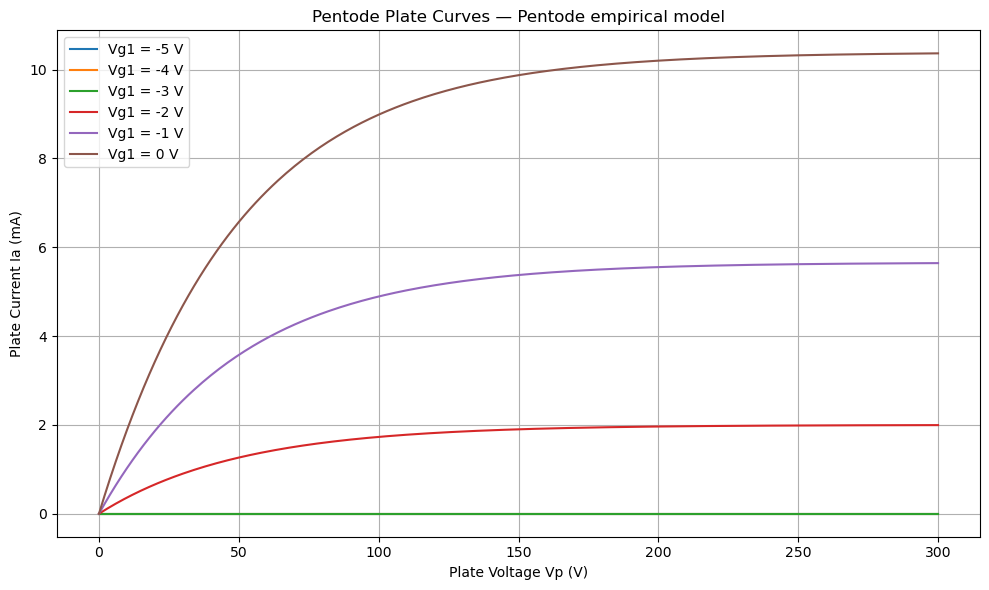

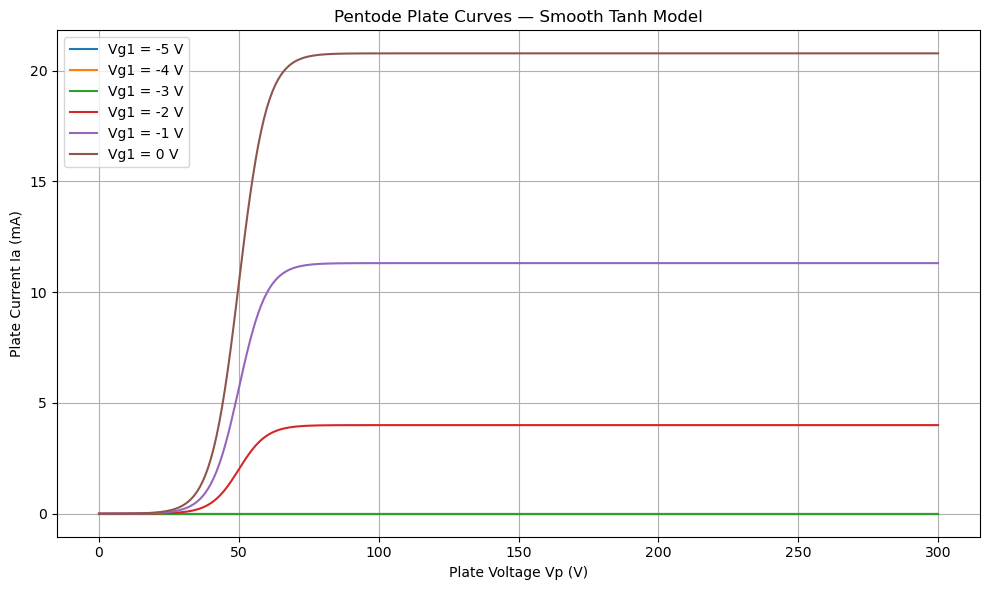

In [69]:
class CustomError(Exception):
    def __init__(self, message="An error occurred", detail=None):
        super().__init__(message)
        self.detail = detail

    def __str__(self):
         return f"{super().__str__()} (Details: {self.detail})" if self.detail else super().__str__()

class Pentode:
    def __init__(self, Vp, Vg_list, Vg2, I0, Vg2_0, Vcut, alpha, beta, Vsat = None, Vknee = None, Vslope = None):
        self.Ip = []
        for Vg1 in Vg_list:
            if Vsat and not (Vknee and Vslope):
                # Pentode empirical model
                Vg1_eff = np.maximum(Vg1 - Vcut, 0)
                term1 = (Vg2 / Vg2_0) ** alpha
                term2 = Vg1_eff ** beta
                term3 = 1 - np.exp(-Vp / Vsat)
                self.Ip.append(I0 * term1 * term2 * term3)
            elif (Vknee and Vslope) and not Vsat:
                # Smoothed pentode model with tanh knee transition
                Vg1_eff = np.maximum(Vg1 - Vcut, 0)
                I_sat = I0 * (Vg2 / Vg2_0)**alpha * Vg1_eff**beta
                transition = 1 - np.tanh((Vknee - Vp) / Vslope)
                self.Ip.append(I_sat * transition)
            else:
                optionals = {"Vsat": Vsat, "Vknee": Vknee, "Vslope": Vslope}
                [print(key) for key, value in optionals.items() if value is None]
                raise CustomError("Missing values", detail="Missing either " + str([key for key, value in optionals.items() if value is None]))
                
Vg2=150
I0=2.0
Vg2_0=150
Vcut=-3.0
alpha=1.0
beta=1.5
Vsat=50

# Voltage Sweep
Vp = np.linspace(0, 300, 301)
Vg1_list = [-5, -4, -3, -2, -1, 0]
pentode = Pentode(Vp, Vg1_list, Vg2, I0, Vg2_0, Vcut, alpha, beta, Vsat = Vsat)

# Plotting
plt.figure(figsize=(10, 6))
for Vg1, Ip in zip(Vg1_list, pentode.Ip):
    plt.plot(Vp, Ip, label=f'Vg1 = {Vg1} V')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.title('Pentode Plate Curves — Pentode empirical model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Vknee=50
Vslope=10
pentode = Pentode(Vp, Vg1_list, Vg2, I0, Vg2_0, Vcut, alpha, beta, Vknee = Vknee, Vslope = Vslope)

# Plotting
plt.figure(figsize=(10, 6))
for Vg1, Ip in zip(Vg1_list, pentode.Ip):
    plt.plot(Vp, Ip, label=f'Vg1 = {Vg1} V')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.title('Pentode Plate Curves — Smooth Tanh Model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
